# Figure 14

Qualitative behavior of the best-fitting models for the two-player experiment. In the first row, the figure presents a two-way scatter plot depicting \Efficiency\ versus \Inequality. Each plot contains 23 data points per group (human and the two best fitting models). Data points in each plot are jittered to improve visibility. The bottom row shows the score in each round averaged over all players.

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import sys

sys.path.append('../src')

from Config.config import PATHS

import warnings
warnings.filterwarnings("ignore")

In [2]:
from Utils.utils import PPT
from Utils.interaction import Performer
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Classes.cognitive_model_agents import AttendanceM2, FRAplus

## Present model fitting

In [3]:
file_2PL = PATHS['parameter_fit_results'] / Path('best_fit_2P.json')
df_2P = pd.read_json(file_2PL, lines=True)
df_2P.index = df_2P.model_name
df_parameters_2P = df_2P[['model_name', 'free_parameters']]
df_2P.drop(columns=['model', 'model_name', 'free_parameters', 'fixed_parameters'], inplace=True)
df_2P.sort_values(by='AIC', inplace=True)
# df_2P.sort_values(by='model_name', inplace=True)
df_2P['deviance'] = df_2P['deviance'].apply(lambda x: int(-x))
df_2P['AIC'] = df_2P['AIC'].apply(lambda x: int(x))
df_2P['AIC_diff'] = df_2P['AIC'] - df_2P['AIC'].min()
df_2P

,deviance,AIC,AIC_diff
model_name,,,
FRA+Payoff+Attendance,2223,4458,0
Attendance-M2,2253,4512,54
Attendance-M3,2253,4512,54
MFP-M2,2560,5125,667
MFP-M3,2560,5125,667
AvailableSpace-M2,2566,5138,680
AvailableSpace-M3,2566,5138,680
FRA,2716,5439,981
Fairness-M2,2791,5589,1131


In [4]:
latex_string = df_2P.to_latex()
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & deviance & AIC & AIC_diff \\
model_name &  &  &  \\
\midrule
FRA+Payoff+Attendance & 2223 & 4458 & 0 \\
Attendance-M2 & 2253 & 4512 & 54 \\
Attendance-M3 & 2253 & 4512 & 54 \\
MFP-M2 & 2560 & 5125 & 667 \\
MFP-M3 & 2560 & 5125 & 667 \\
AvailableSpace-M2 & 2566 & 5138 & 680 \\
AvailableSpace-M3 & 2566 & 5138 & 680 \\
FRA & 2716 & 5439 & 981 \\
Fairness-M2 & 2791 & 5589 & 1131 \\
Fairness-M3 & 2791 & 5589 & 1131 \\
Payoff-M2 & 2796 & 5597 & 1139 \\
Payoff-M3 & 2796 & 5597 & 1139 \\
WSLS-M2 & 2918 & 5843 & 1385 \\
WSLS-M3 & 2918 & 5843 & 1385 \\
Priors-M3 & 2968 & 5954 & 1496 \\
Priors-M2 & 2968 & 5962 & 1504 \\
Attendance-M1 & 3062 & 6130 & 1672 \\
Priors-M1 & 3133 & 6272 & 1814 \\
AvailableSpace-M1 & 3164 & 6335 & 1877 \\
MFP-M1 & 3166 & 6336 & 1878 \\
Payoff-M1 & 3177 & 6358 & 1900 \\
WSLS-M1 & 3182 & 6371 & 1913 \\
Fairness-M1 & 3188 & 6382 & 1924 \\
\bottomrule
\end{tabular}



In [5]:
latex_string_parameters = ''

for model, row in df_parameters_2P.iterrows():
    if model in ['Attendance-M2', 'FRA+Payoff+Attendance']:
        parameters = row['free_parameters']
        print('-'*60)
        print(model)
        print(parameters)

------------------------------------------------------------
Attendance-M2
{'inverse_temperature': 6.154017841, 'learning_rate': 0.20037471880000002, 'bias': 0.7566579015}
------------------------------------------------------------
FRA+Payoff+Attendance
{'inverse_temperature': 6.3844949711, 'bias': 0.7478171885, 'learning_rate': 0.19868152790000002, 'len_history': 1.0274636861, 'max_regions': 1.1292748336, 'delta': 0.0542665395}


## Simulate two best fit models

In [6]:
def get_free_parameters(model_name, params_dict):
    model_names = df_parameters_2P['model_name'].tolist()
    idx = model_names.index(model_name)
    return df_parameters_2P['free_parameters'][idx]

# BEST_MODEL = AttendanceM2
BEST_MODEL = FRAplus

fixed_parameters = {
	"num_agents":2,
	"threshold":0.5,
}
free_parameters = {
    'inverse_temperature': 6, 
    'bias': 0.79, 
    'learning_rate': 0.18, 
    'len_history': 2, 
    'c': 1, 
    'delta': 0.1
}
simulation_parameters = {
	'num_rounds':50,
	'verbose':False
}

In [7]:
data_folder = PATHS['simulated_data']
num_episodes = 23 # same as human groups
random.seed(4)
seeds = [random.randint(0, 1000) for _ in range(num_episodes)]

Performer.simple_run(
    agent_class=BEST_MODEL,
    fixed_parameters=fixed_parameters,
    free_parameters=free_parameters,
    simulation_parameters=simulation_parameters,
    measures=[],
    data_folder=data_folder,
    new_file=False,
    seeds=seeds
)

Running seeds...:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Data saved to /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/simulated/FRA+Payoff+Attendance.csv


## Compare to human data

In [13]:
#Load 2P data
file_name = PATHS['human_data'] / '2-player-UR.csv'
data_human = pd.read_csv(file_name)
data_human['model'] = 'human'

#Load data from FRAplus
file1 = PATHS['simulated_data'] / Path(f'{FRAplus.name()}.csv')
data_sim1 = pd.read_csv(file1)
data_sim1['model'] = FRAplus.name()

#Load data from Attendance-M2
file2 = PATHS['simulated_data'] / Path(f'{AttendanceM2.name()}.csv')
data_sim2 = pd.read_csv(file2)
data_sim2['model'] = AttendanceM2.name()

# Calculate alternation index per group for FRAplus
raw_df1 = PPT.concat_dfs(data_human, data_sim1)
gm = GetMeasurements(
    data=raw_df1,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df1 = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df1['alternation_index'] = alt_index(df1)
df_jitter1 = df1.copy()
df_jitter1['efficiency'] = df_jitter1['efficiency'] + np.random.normal(0, 0.01, len(df_jitter1['efficiency']))
df_jitter1['inequality'] = df_jitter1['inequality'] + np.random.normal(0, 0.01, len(df_jitter1['inequality']))

# Calculate alternation index per group for Attendance
raw_df2 = PPT.concat_dfs(data_human, data_sim2)
gm = GetMeasurements(
    data=raw_df2,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df2 = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df2['alternation_index'] = alt_index(df2)
df_jitter2 = df2.copy()
df_jitter2['efficiency'] = df_jitter2['efficiency'] + np.random.normal(0, 0.01, len(df_jitter2['efficiency']))
df_jitter2['inequality'] = df_jitter2['inequality'] + np.random.normal(0, 0.01, len(df_jitter2['inequality']))

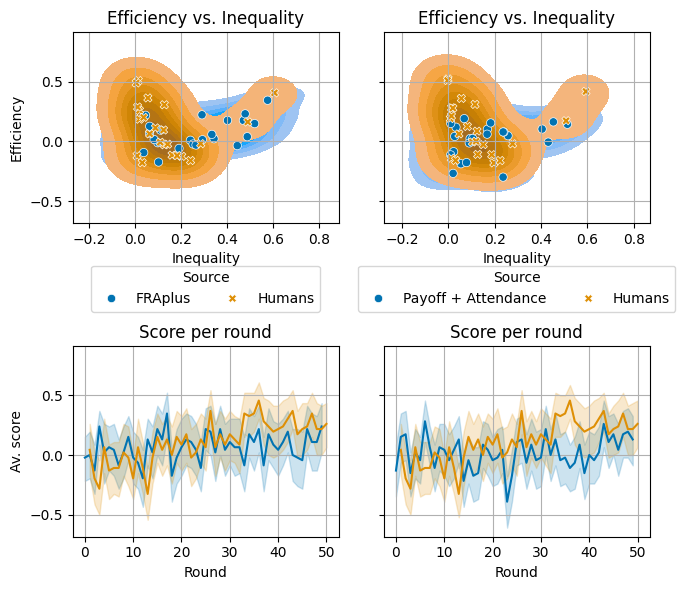

In [18]:

grid = Grid(4)
fig, axes = plt.subplots(
    grid.rows, grid.cols,
    figsize=(grid.cols * 3.5, grid.rows * 3),
    tight_layout=True,
    sharex=False, sharey=True    
)

sns.kdeplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind', fill=True,
    ax=axes[0, 0]
)
sns.scatterplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind',
    ax=axes[0, 0]
)
axes[0, 0].set_xlabel('Inequality')
axes[0, 0].set_ylabel('Efficiency')
axes[0, 0].set_title('Efficiency vs. Inequality')
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(
    title='Source',
    handles=handles,
    labels=['FRAplus', 'Humans'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.5),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)
axes[0, 0].grid()

sns.kdeplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter2, palette='colorblind', fill=True,
    ax=axes[0, 1]
)
sns.scatterplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter2, palette='colorblind',
    ax=axes[0, 1]
)
axes[0, 1].set_xlabel('Inequality')
axes[0, 1].set_ylabel('Efficiency')
axes[0, 1].set_title('Efficiency vs. Inequality')
handles, labels = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(
    title='Source',
    handles=handles,
    labels=['Payoff + Attendance', 'Humans'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.5),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)
axes[0, 1].grid()


sns.lineplot(
    x='round', y='score', 
    hue='model', hue_order=[FRAplus.name(), 'human'],
    data=raw_df1, palette='colorblind',
    ax=axes[1,0]
)
axes[1, 0].set_xlabel('Round')
axes[1, 0].set_ylabel('Av. score')
axes[1, 0].set_title('Score per round')
axes[1,0].legend().remove()
axes[1, 0].grid()

sns.lineplot(
    x='round', y='score', 
    hue='model', hue_order=[AttendanceM2.name(), 'human'],
    data=raw_df2, palette='colorblind',
    ax=axes[1,1]
)
axes[1, 1].set_xlabel('Round')
axes[1, 1].set_ylabel('Av. score')
axes[1, 1].set_title('Score per round')
axes[1, 1].legend().remove()
axes[1, 1].grid()

In [19]:
fig.savefig(PATHS['figures_for_paper'] / 'Figure14.png', dpi=300, bbox_inches='tight')

---